# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import quandl

In [3]:
from utils import *

In [4]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key
tickers, prices = get_quandl_sharadar(free=False)

In [5]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Ticker,Date,,,,,,,,
AABA,1998-12-31,30.238,31.875,29.000,29.613,37516800.00,0.0,236.900,2018-02-11
AAC1,1998-12-31,3.438,3.750,3.375,3.625,561000.00,0.0,3.625,2018-04-16
AACB,1998-12-31,16.750,16.750,16.438,16.438,1600.00,0.0,16.438,2018-02-11
AAME,1998-12-31,4.750,4.875,4.750,4.875,9700.00,0.0,4.875,2018-02-11
AAN,1998-12-31,4.409,4.444,4.409,4.427,3300.75,0.0,14.940,2018-02-11
...,...,...,...,...,...,...,...,...,...
ZTS,2018-07-09,86.900,87.710,86.620,87.490,1834672.00,0.0,87.490,2018-07-09
ZUMZ,2018-07-09,23.750,24.300,23.650,24.050,408607.00,0.0,24.050,2018-07-09
ZUO,2018-07-09,26.710,27.000,25.610,26.070,1325274.00,0.0,26.070,2018-07-09


# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

4911 days.


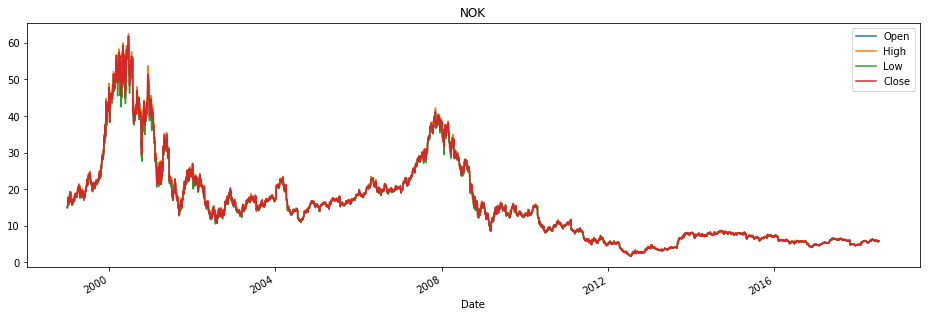

In [108]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [109]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [110]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [111]:
N_ga = 151
f_ga = gaussian(N_ga, std=20.)
f_ga = f_ga / f_ga.sum()

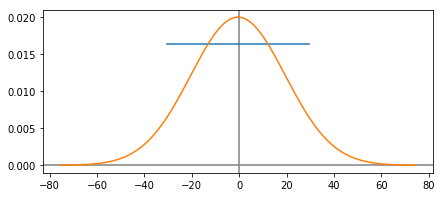

In [112]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Wiener 

In [113]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [114]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

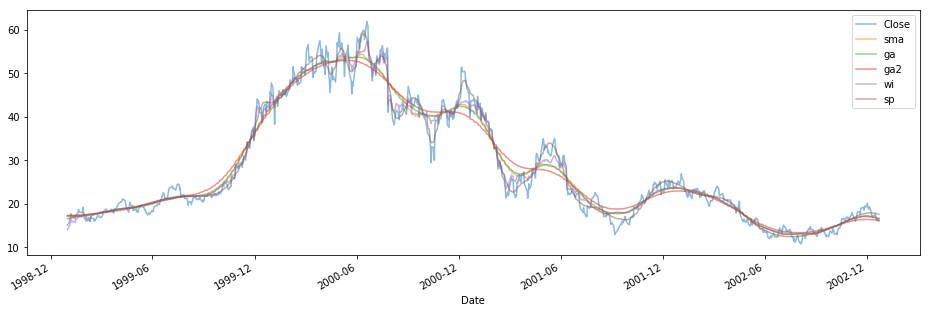

In [115]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
                                  wi=f_wi(price.Close),
                                  sp=f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

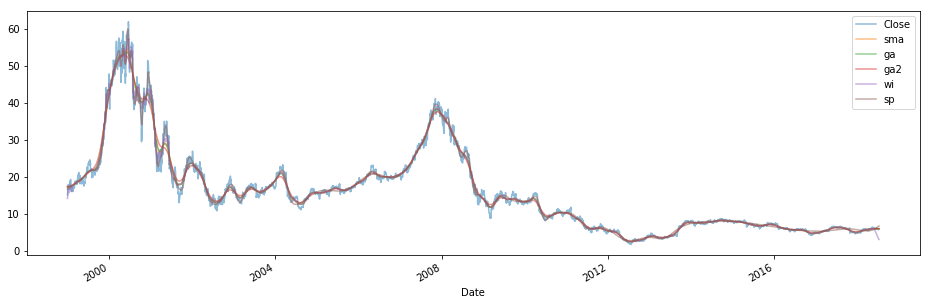

In [116]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [117]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [118]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [119]:
# results = results.assign(smoothed=results.ga)
results = smooth_price(price)
# results = results[:1000]

In [120]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed
Date,,,,,,,,,
1998-12-31,14.925,15.200,14.925,15.050,3681600.0,0.0,120.40,2018-02-11,17.203855
1999-01-04,16.125,16.438,15.887,16.025,14688000.0,0.0,128.20,2018-02-11,17.204343
1999-01-05,16.788,16.913,16.663,16.813,12175200.0,0.0,134.50,2018-02-11,17.205276
1999-01-06,17.625,17.813,17.313,17.788,18050400.0,0.0,142.30,2018-02-11,17.206657
1999-01-07,17.137,17.563,16.813,17.500,19007200.0,0.0,140.00,2018-02-11,17.208511
...,...,...,...,...,...,...,...,...,...
2018-07-02,5.620,5.670,5.610,5.650,12532819.0,0.0,5.65,2018-07-02,5.907836
2018-07-03,5.670,5.710,5.644,5.680,8570561.0,0.0,5.68,2018-07-03,5.906735
2018-07-05,5.690,5.740,5.665,5.730,11287105.0,0.0,5.73,2018-07-05,5.905902


In [121]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [122]:
# Begining
if valleys.min() < peaks.min():
    peaks = np.concatenate((-np.ones(1, dtype=np.int32), peaks))
else:
    valleys = np.concatenate((-np.ones(1, dtype=np.int32), valleys))

# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32)*len(results) - 2))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32)*len(results) - 2))

> TO DO: Checks.

In [123]:
results.loc[results.index[peaks + 1], 'Trend'] = -1
results.loc[results.index[valleys + 1], 'Trend'] = 1
results.Trend.fillna(method='ffill', inplace=True)

In [124]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown
Date,,,,,,,,,,,
1998-12-31,14.925,15.200,14.925,15.050,3681600.0,0.0,120.40,2018-02-11,17.203855,1.0,NaN
1999-01-04,16.125,16.438,15.887,16.025,14688000.0,0.0,128.20,2018-02-11,17.204343,1.0,NaN
1999-01-05,16.788,16.913,16.663,16.813,12175200.0,0.0,134.50,2018-02-11,17.205276,1.0,NaN
1999-01-06,17.625,17.813,17.313,17.788,18050400.0,0.0,142.30,2018-02-11,17.206657,1.0,NaN
1999-01-07,17.137,17.563,16.813,17.500,19007200.0,0.0,140.00,2018-02-11,17.208511,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-07-02,5.620,5.670,5.610,5.650,12532819.0,0.0,5.65,2018-07-02,5.907836,-1.0,NaN
2018-07-03,5.670,5.710,5.644,5.680,8570561.0,0.0,5.68,2018-07-03,5.906735,-1.0,NaN
2018-07-05,5.690,5.740,5.665,5.730,11287105.0,0.0,5.73,2018-07-05,5.905902,-1.0,NaN


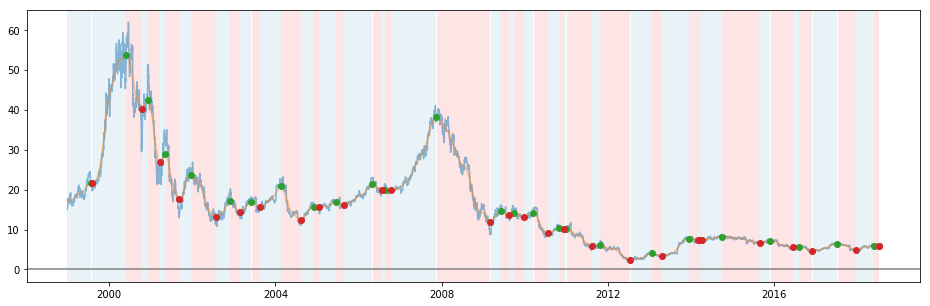

In [125]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [126]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

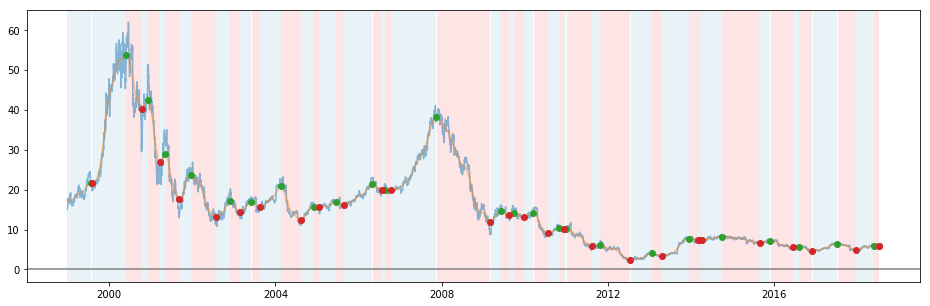

In [127]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [128]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[4.91142334e-01, 0.00000000e+00],
       [2.03624516e-04, 5.08654042e-01]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [129]:
breakpoints = np.concatenate((-np.ones(1, dtype=np.int32), peaks, valleys))
breakpoints.sort()
print('Breakpoints:', breakpoints)

Breakpoints: [  -1  145  149  357  451  487  559  592  677  746  897  983 1043 1111
 1162 1289 1409 1489 1520 1622 1672 1844 1901 1921 1956 2233 2557 2622
 2667 2698 2760 2818 2904 2975 3004 3019 3174 3222 3406 3535 3593 3762
 3815 3821 3838 3958 4189 4254 4389 4428 4509 4658 4772 4881 4909 4910]


In [130]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1] + 1
    trend_end = breakpoints[b] + 1
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [131]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,
1998-12-31,14.925,15.200,14.925,15.050,3681600.0,0.0,120.40,2018-02-11,17.203855,1.0,0.174533,1.0
1999-01-04,16.125,16.438,15.887,16.025,14688000.0,0.0,128.20,2018-02-11,17.204343,1.0,0.174533,1.0
1999-01-05,16.788,16.913,16.663,16.813,12175200.0,0.0,134.50,2018-02-11,17.205276,1.0,0.174533,1.0
1999-01-06,17.625,17.813,17.313,17.788,18050400.0,0.0,142.30,2018-02-11,17.206657,1.0,0.174533,1.0
1999-01-07,17.137,17.563,16.813,17.500,19007200.0,0.0,140.00,2018-02-11,17.208511,1.0,0.174533,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-02,5.620,5.670,5.610,5.650,12532819.0,0.0,5.65,2018-07-02,5.907836,-1.0,0.055050,-1.0
2018-07-03,5.670,5.710,5.644,5.680,8570561.0,0.0,5.68,2018-07-03,5.906735,-1.0,0.055050,-1.0
2018-07-05,5.690,5.740,5.665,5.730,11287105.0,0.0,5.73,2018-07-05,5.905902,-1.0,0.055050,-1.0


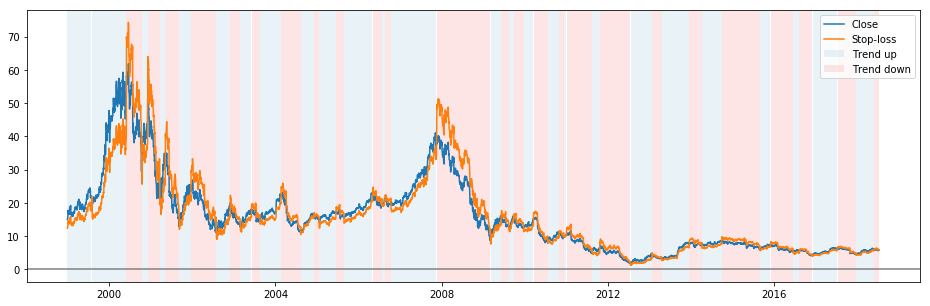

In [132]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.show()

# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).